In [15]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Pulse Radar Altimeter: Altitude Measurement over Terrain

## Introduction

This notebook demonstrates how to use **RadarSimPy** to simulate a **pulse radar altimeter**—a specialized radar system that measures altitude by transmitting short pulses downward and measuring the time delay of ground reflections. This example showcases RadarSimPy's capabilities for simulating airborne radar systems with complex terrain interactions.

### Radar Altimeter Simulation with RadarSimPy

**Simulation Capabilities:**

RadarSimPy allows you to:

1. **Configure Radar Parameters**: Define frequency, power, pulse width, and PRF
2. **Model Antenna Patterns**: Create custom gain patterns with azimuth/elevation tapers
3. **Position Radar Platform**: Place radar at any altitude and orientation
4. **Load Terrain Models**: Import 3D terrain surfaces for realistic ground scatter
5. **Generate Signals**: Simulate received baseband signals with terrain reflections
6. **Process Returns**: Apply matched filtering and extract altitude information

**Time-Delay Principle:**

The fundamental altitude equation:

$$h = \frac{c \cdot \tau}{2}$$

Where:
- $h$ = Altitude above terrain (m)
- $c$ = Speed of light (3×10⁸ m/s)
- $\tau$ = Round-trip time delay (s)
- Factor 2 accounts for two-way propagation

### RadarSimPy Altimeter Example Parameters

**Radar Configuration:**

- **Carrier Frequency**: 10 GHz (X-band)
- **Peak Power**: 1 MW (90 dBm)
- **Pulse Width**: ~333 ns (altitude resolution: 50 m)
- **PRF**: 30 kHz
- **Sampling Rate**: 6 MHz
- **Antenna Gain**: 20 dBi with narrow beam pattern

**Platform Setup:**

- **Altitude**: 4000 m above terrain
- **Antenna Pointing**: Nadir (downward)
- **Terrain Model**: Grand Canyon 3D surface
- **Footprint Size**: ~140 m diameter on terrain

**Processing:**

- Matched filtering with transmitted pulse replica
- Baseband signal generation
- Altitude extraction from ground return peak

### What You'll Learn

This notebook demonstrates how to use RadarSimPy to:

- **Configure a pulse radar altimeter** using `Radar`, `Transmitter`, and `Receiver` classes
- **Define custom antenna patterns** with azimuth and elevation gain tapers
- **Position the radar platform** at operational altitude with proper orientation
- **Load and visualize 3D terrain models** for realistic ground scatter simulation
- **Generate radar baseband signals** with terrain reflections and noise
- **Apply matched filtering** to extract altitude information from returns
- **Visualize simulation results** including terrain geometry and signal processing
- **Interpret radar measurements** with terrain footprint effects

### Why Use RadarSimPy for Altimeter Simulation?

**Advantages:**

1. **Realistic Physics**: Accurate propagation, reflection, and noise modeling
2. **Flexible Configuration**: Easy parameter adjustment for different scenarios
3. **Complex Terrain**: Support for 3D surface models and scatter characteristics
4. **Complete Workflow**: From radar configuration to signal processing
5. **Python Integration**: Works seamlessly with NumPy, SciPy, and visualization libraries
6. **Educational Value**: Clear demonstration of radar altimeter principles

**Applications:**

- **System Design**: Evaluate altimeter configurations before hardware
- **Algorithm Development**: Test signal processing approaches
- **Performance Analysis**: Assess altitude accuracy and resolution
- **Training**: Understand radar altimeter operation and limitations

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate a complete radar altimeter scenario over the Grand Canyon terrain, demonstrating:

- RadarSimPy radar configuration with pulse waveform
- Custom antenna pattern definition for narrow-beam altimeter
- 3D terrain model loading and visualization
- Baseband signal generation with ground returns
- Matched filter processing for altitude extraction
- Comprehensive visualization of geometry and results

The simulation provides a practical example of using RadarSimPy for airborne radar applications with realistic terrain interactions.

## Radar System Configuration

Configure pulse radar altimeter using RadarSimPy's `Radar`, `Transmitter`, and `Receiver` classes.

### Import Required Modules

Import RadarSimPy modules for radar simulation and visualization.

In [16]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Antenna Pattern Definition

Define downward-looking antenna radiation pattern for the altimeter using RadarSimPy's custom pattern specification.

**Antenna Characteristics:**

- **Gain**: 20 dBi (directional antenna)
- **Azimuth**: cos³⁰ taper for moderate beamwidth (~15°)
- **Elevation**: cos⁴⁰ taper for moderate beamwidth (~13°)
- **Angular Range**: -5° to +5° in 1° steps (11 points)
- **Pointing**: Configured for nadir orientation

The moderate beam provides good balance between footprint size and signal strength, typical for aircraft radar altimeters.


In [17]:
# Define antenna gain
antenna_gain = 20  # dBi - High-gain directional antenna

### Azimuth Pattern (Horizontal Plane) ###

# Define azimuth angle array: -5° to +5° in 1° steps
az_angle = np.arange(-5, 6, 1)  # 11 points

# Azimuth pattern: cos^30 taper with 20 dBi gain
# Moderate beamwidth (~15° @ -3dB) suitable for altimeter
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 30) + antenna_gain  # dB

### Elevation Pattern (Vertical Plane) ###

# Define elevation angle array: -5° to +5° in 1° steps
el_angle = np.arange(-5, 6, 1)  # 11 points

# Elevation pattern: cos^40 taper with 20 dBi gain
# Moderate beamwidth (~13° @ -3dB) suitable for altimeter
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 40) + antenna_gain  # dB

### Altimeter Waveform Parameters

Calculate pulse altimeter waveform parameters using RadarSimPy based on altitude measurement requirements.

**Design Requirements:**

- **Maximum Range**: 5000 m → determines PRF
- **Range Resolution**: 50 m → determines pulse bandwidth and width

**Calculated Parameters:**

- **Pulse Bandwidth**: B = c/(2ΔR) = 3 MHz
- **Pulse Width**: Tp = 1/B ≈ 333 ns (rectangular pulse)
- **PRF**: c/(2R_max) = 30 kHz
- **PRP**: 1/PRF ≈ 33.3 μs
- **Duty Cycle**: ~1%
- **Sampling Rate**: 6 MHz (exceeds Nyquist requirement)
- **Carrier Frequency**: 10 GHz (X-band)
- **Number of Pulses**: 1 (for demonstration)

The code creates a rectangular pulse envelope where amplitude = 1 for the pulse duration and 0 elsewhere, configured through the `Transmitter` class with pulse modulation.


In [18]:
# Import constants
from scipy import constants

# Speed of light constant
light_speed = constants.c  # 299,792,458 m/s

### Calculate Pulsed Radar Waveform Parameters ###

# Performance Requirements
max_range = 5000  # Maximum unambiguous range: 5000 m (5 km)
range_res = 50  # Required range resolution: 50 m

# Derived Waveform Parameters
pulse_bw = light_speed / (2 * range_res)  # Pulse bandwidth: c/(2*ΔR) = 3 MHz
pulse_width = 1 / pulse_bw  # Pulse width: 1/B ≈ 333 ns
prf = light_speed / (2 * max_range)  # PRF: c/(2*R_max) = 30 kHz
prp = 1 / prf  # PRP: 1/PRF ≈ 33.3 μs

# Radar Parameters
fs = 6e6  # Sampling rate: 6 MHz (> 2 × pulse_bw for Nyquist)
fc = 10e9  # Carrier frequency: 10 GHz (X-band)
num_pulse = 1  # Number of pulses: 1 (for single pulse demonstration)

# Calculate sample counts
total_samples = int(prp * num_pulse * fs)  # Total samples in observation
sample_per_pulse = int(total_samples / num_pulse)  # Samples per pulse

### Create Rectangular Pulse Envelope ###

# Create time array for modulation (spans entire observation)
mod_t = np.arange(0, total_samples) / fs  # Time vector (seconds)

# Initialize amplitude modulation array (all zeros initially)
amp = np.zeros_like(mod_t)

# Set pulse-on period: amplitude = 1 for duration of pulse_width
amp[mod_t <= pulse_width] = 1  # Rectangular pulse (first ~333 ns)

### Define Transmitter Channel ###

# Configure TX channel with antenna pattern and pulse modulation
tx_channel = dict(
    location=(0, 0, 0),  # Antenna position at origin
    azimuth_angle=az_angle,  # Azimuth angles array
    azimuth_pattern=az_pattern,  # Azimuth gain pattern (dB)
    elevation_angle=el_angle,  # Elevation angles array
    elevation_pattern=el_pattern,  # Elevation gain pattern (dB)
    amp=amp,  # Pulse amplitude modulation
    mod_t=mod_t,  # Modulation time array
)

### Create Pulsed Radar Transmitter ###

tx = Transmitter(
    f=fc,  # Carrier frequency: 10 GHz
    t=1 / prf,  # Pulse duration: PRP ≈ 33.3 μs
    tx_power=90,  # Transmit power: 90 dBm = 1 MW
    pulses=num_pulse,  # Number of pulses: 1
    channels=[tx_channel],  # Transmitter antenna configuration
)

# Display calculated parameters
print(f"Pulsed Radar Waveform Parameters:")
print(f"  Pulse Width: {pulse_width*1e9:.2f} ns")
print(f"  Pulse Bandwidth: {pulse_bw/1e6:.1f} MHz")
print(f"  PRF: {prf/1e3:.1f} kHz")
print(f"  PRP: {prp*1e6:.2f} μs")
print(f"  Duty Cycle: {(pulse_width/prp)*100:.2f}%")
print(f"  Samples per Pulse: {sample_per_pulse}")
print(f"  Number of Pulses: {num_pulse}")

Pulsed Radar Waveform Parameters:
  Pulse Width: 333.56 ns
  Pulse Bandwidth: 3.0 MHz
  PRF: 30.0 kHz
  PRP: 33.36 μs
  Duty Cycle: 1.00%
  Samples per Pulse: 200
  Number of Pulses: 1


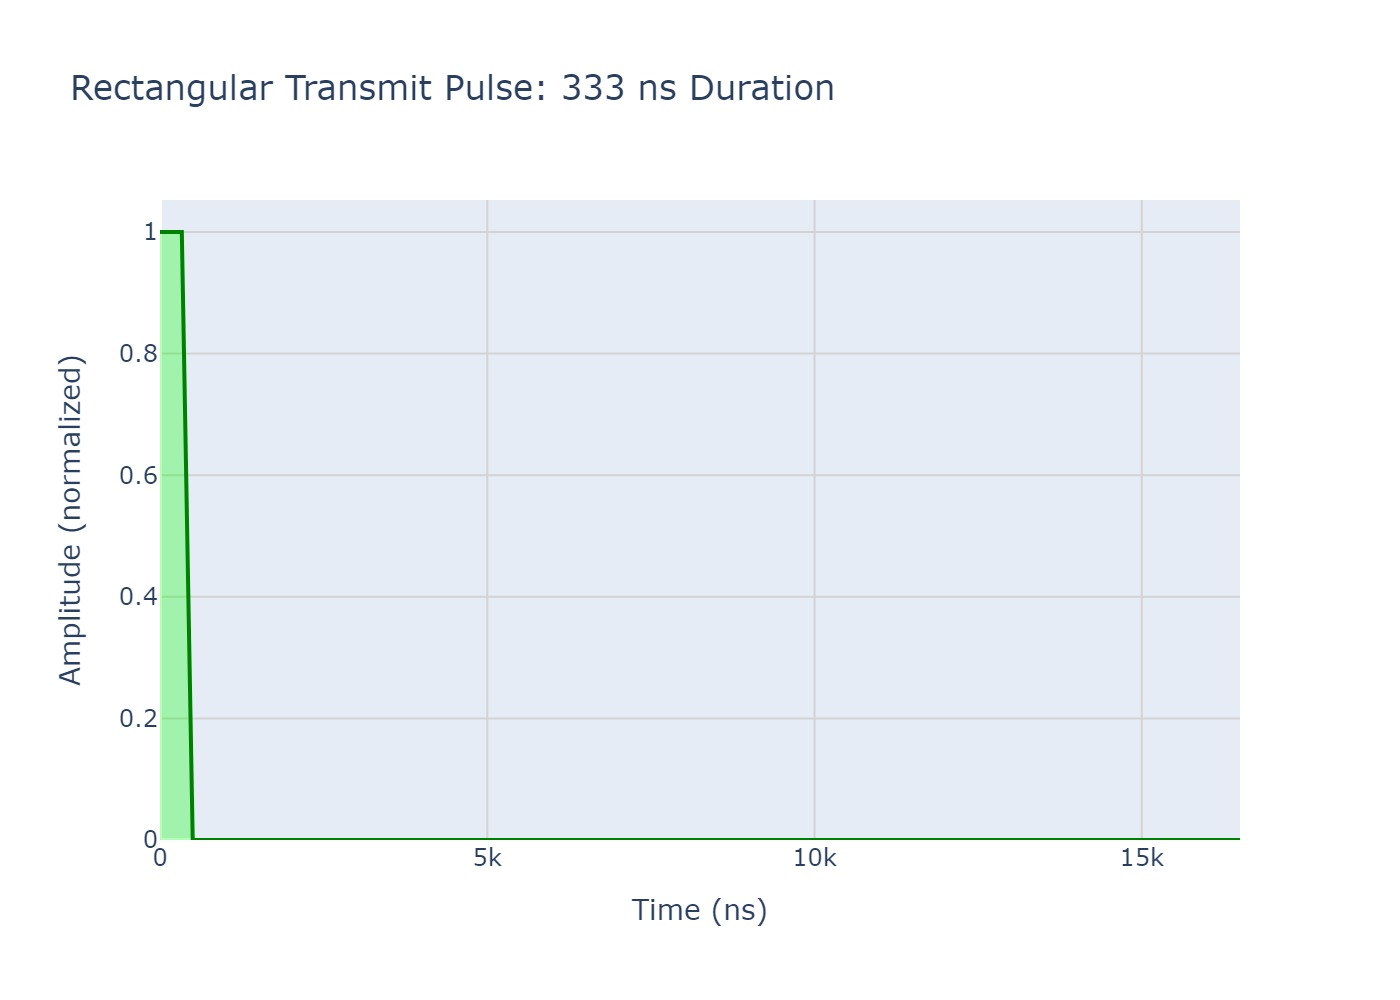

In [19]:
import plotly.graph_objs as go
from IPython.display import Image, display

# Create figure for pulse visualization
fig = go.Figure()

# Plot pulse envelope (first 100 samples to show detail)
fig.add_trace(
    go.Scatter(
        x=mod_t[0:100] * 1e9,  # Convert to nanoseconds
        y=amp[0:100],  # Pulse amplitude
        name="Transmit Pulse",
        line=dict(color="green", width=2),
        fill="tozeroy",
        fillcolor="rgba(0,255,0,0.3)",
    )
)

# Configure plot layout
fig.update_layout(
    title="Rectangular Transmit Pulse: 333 ns Duration",
    yaxis=dict(title="Amplitude (normalized)", gridcolor="lightgray"),
    xaxis=dict(title="Time (ns)", gridcolor="lightgray"),
    height=500,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Receiver Configuration

Configure receiver for baseband sampling and ground return detection using RadarSimPy's `Receiver` class.

**Monostatic Configuration:**

The receiver channel uses the same antenna pattern as the transmitter (co-located TX/RX at origin).

**Receiver Parameters:**

- **Sampling Rate**: 6 MHz
- **Noise Figure**: 6 dB
- **RF Gain**: 20 dB
- **Baseband Gain**: 80 dB
- **Load Resistor**: 500 Ω

These parameters are passed to the `Receiver` class constructor along with the channel configuration.

In [20]:
# Define receiver channel with same antenna pattern (monostatic)
rx_channel = dict(
    location=(0, 0, 0),  # Receiver position at origin (same as TX)
    azimuth_angle=az_angle,  # Same azimuth pattern as TX
    azimuth_pattern=az_pattern,  # Same azimuth gain
    elevation_angle=el_angle,  # Same elevation pattern
    elevation_pattern=el_pattern,  # Same elevation gain
)

In [21]:
# Create pulsed radar receiver
rx = Receiver(
    fs=fs,  # Sampling rate: 6 MHz
    noise_figure=6,  # Noise figure: 6 dB
    rf_gain=20,  # RF gain: 20 dB (LNA)
    load_resistor=500,  # Load resistance: 500 Ω
    baseband_gain=80,  # Baseband gain: 80 dB
    channels=[rx_channel],  # Receiver antenna configuration
)

### Create Radar Altimeter System

Combine transmitter and receiver using RadarSimPy's `Radar` class to form the complete radar altimeter.


**Platform Configuration:**

The rotation of -90° in pitch rotates the antenna beam downward for altitude measurement.

- **Location**: (10000, 30000, 4000) m → 4000m altitude

- **Speed**: (200, 0, 0) m/s → 200 m/s in x-direction- **Measurement Time**: 0 to 150 seconds in 1-second intervals
- **Rotation**: (0, -90, 0) degrees → antenna pointing downward (nadir)

In [22]:
measurement_time = np.arange(0, 150, 1)  # Time vector for measurement
radar_location = (10000, 30000, 4000)  # Radar location (x, y, z) in meters
radar_speed = (200, 0, 0)  # Radar speed (x, y, z) in m/s

# Create complete pulsed radar system
radar = Radar(
    transmitter=tx,
    receiver=rx,
    location=radar_location,
    speed=radar_speed,
    rotation=(0, -90, 0),
    frame_time=measurement_time,
)  # Monostatic radar at specified location

## Terrain Configuration

Define terrain surface using RadarSimPy's target configuration.

### Terrain Model

**Target Configuration:**

The terrain is defined as a target with:

- **Model**: `../models/grand_canyon.stl` (3D mesh)
- **Units**: meters
- **Location**: (0, 0, 0) origin
- **Speed**: (0, 0, 0) stationary
- **Permittivity**: 5 (typical soil)

**Simulation Geometry:**

- **Radar Altitude**: 4000 m above terrain
- **Flight Path**: Moving at 200 m/s over 150 seconds
- **Terrain**: Complex Grand Canyon surface with elevation variations

**Expected Ground Returns:**

- Main return peak at ~4000m range (altitude above terrain)
- Signal spreading from terrain elevation variations
- Realistic scatter from 3D mesh geometry

In [23]:
# Configure Target 1: Terrain model
target_1 = {
    "model": "../models/grand_canyon.stl",  # Terrain 3D model
    "unit": "m",  # Model units in meters
    "location": (0, 0, 0),  # Position: Origin
    "speed": (0, 0, 0),  # Velocity: Stationary
    "permittivity": 5,
}

# Combine targets for simulation
targets = [target_1]

### Visualize Terrain Model

Load and display the 3D Grand Canyon terrain mesh using PyMeshLab and Plotly.


The visualization shows:

- Terrain mesh colored by elevation (z-coordinate)- 3D perspective view of the altimeter scenario
- Flight path overlaid as blue line with markers

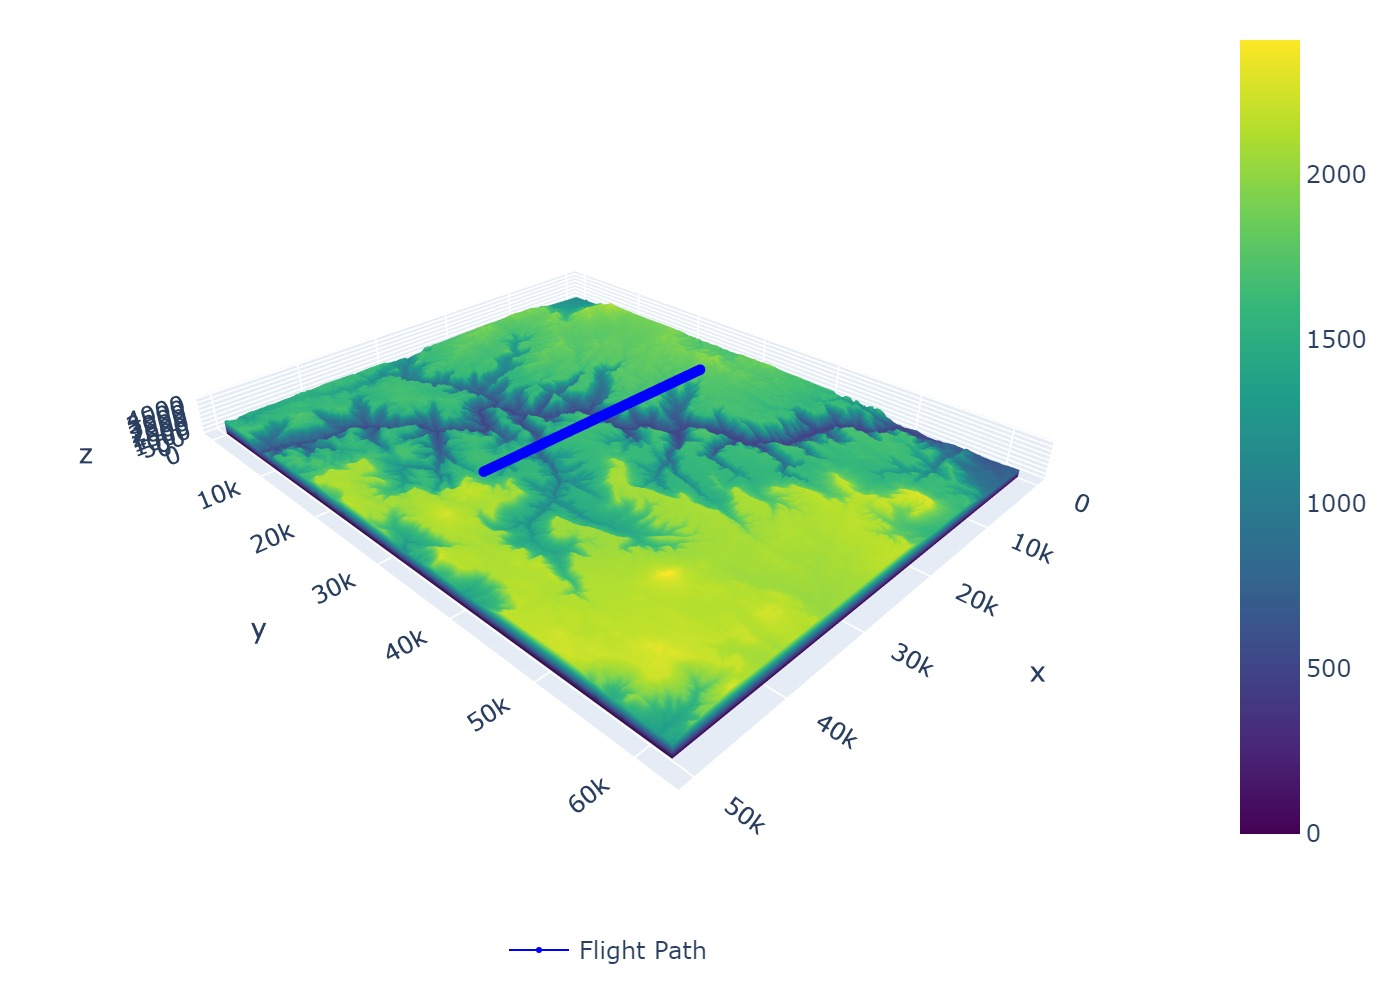

In [24]:
# Import libraries for 3D visualization
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

# Load terrain 3D mesh
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())  # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],  # X coordinates
        y=v_matrix[:, 1],  # Y coordinates
        z=v_matrix[:, 2],  # Z coordinates
        i=f_matrix[:, 0],  # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",  # Color scheme
        name="Terrain",
    )
)

# Add flight path visualization
flight_path_x = radar_location[0] + radar_speed[0] * measurement_time
flight_path_y = radar_location[1] + radar_speed[1] * measurement_time
flight_path_z = radar_location[2] + radar_speed[2] * measurement_time

fig.add_trace(
    go.Scatter3d(
        x=flight_path_x,
        y=flight_path_y,
        z=flight_path_z,
        mode="lines+markers",
        line=dict(color="blue", width=1),
        marker=dict(size=3, color="blue"),
        name="Flight Path",
    )
)

# Configure 3D plot layout with zoomed out camera
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["scene"]["camera"] = dict(
    eye=dict(x=2.5, y=2.5, z=2),  # Zoomed out camera position
    center=dict(x=0, y=0, z=0),
    up=dict(x=0, y=0, z=1),
)
fig["layout"]["height"] = 500  # Plot height in pixels
fig["layout"]["margin"] = dict(
    l=10, r=10, b=30, t=10
)  # Increased bottom margin for legend
fig["layout"]["showlegend"] = True  # Show legend
fig["layout"]["legend"] = dict(
    orientation="h",  # Horizontal orientation
    yanchor="bottom",
    y=-0.15,  # Position below the plot
    xanchor="center",
    x=0.5,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Simulate Baseband Signals

Generate radar altimeter baseband signals using RadarSimPy's `sim_radar` function.

**Output Data:**

- **baseband**: Complex I/Q signals [frames, pulses, samples]
- **noise**: Thermal noise component
- **timestamp**: Time array for each sample

The combined signal (baseband + noise) contains terrain returns at ~4000m range with realistic scatter and noise.


In [25]:
# Import radar simulator
from radarsimpy.simulator import sim_radar

# Simulate pulsed radar with terrain target
data = sim_radar(radar, targets, density=0.05)

# Extract simulation results
timestamp = data["timestamp"]  # Time array
baseband = data["baseband"] + data["noise"]  # Complex I/Q + noise

print(f"Simulation complete:")
print(f"  Baseband shape: {baseband.shape}")
print(f"  Number of frames: {baseband.shape[0]}")
print(f"  Samples per pulse: {baseband.shape[2]}")

Simulation complete:
  Baseband shape: (150, 1, 200)
  Number of frames: 150
  Samples per pulse: 200


### Visualize Baseband Signals

Plot the first 3 measurements showing I (real) and Q (imaginary) channels.


The plot displays:

- Time in microseconds (μs)- Background thermal noise

- I and Q signal amplitudes- Ground return peaks visible in the signals

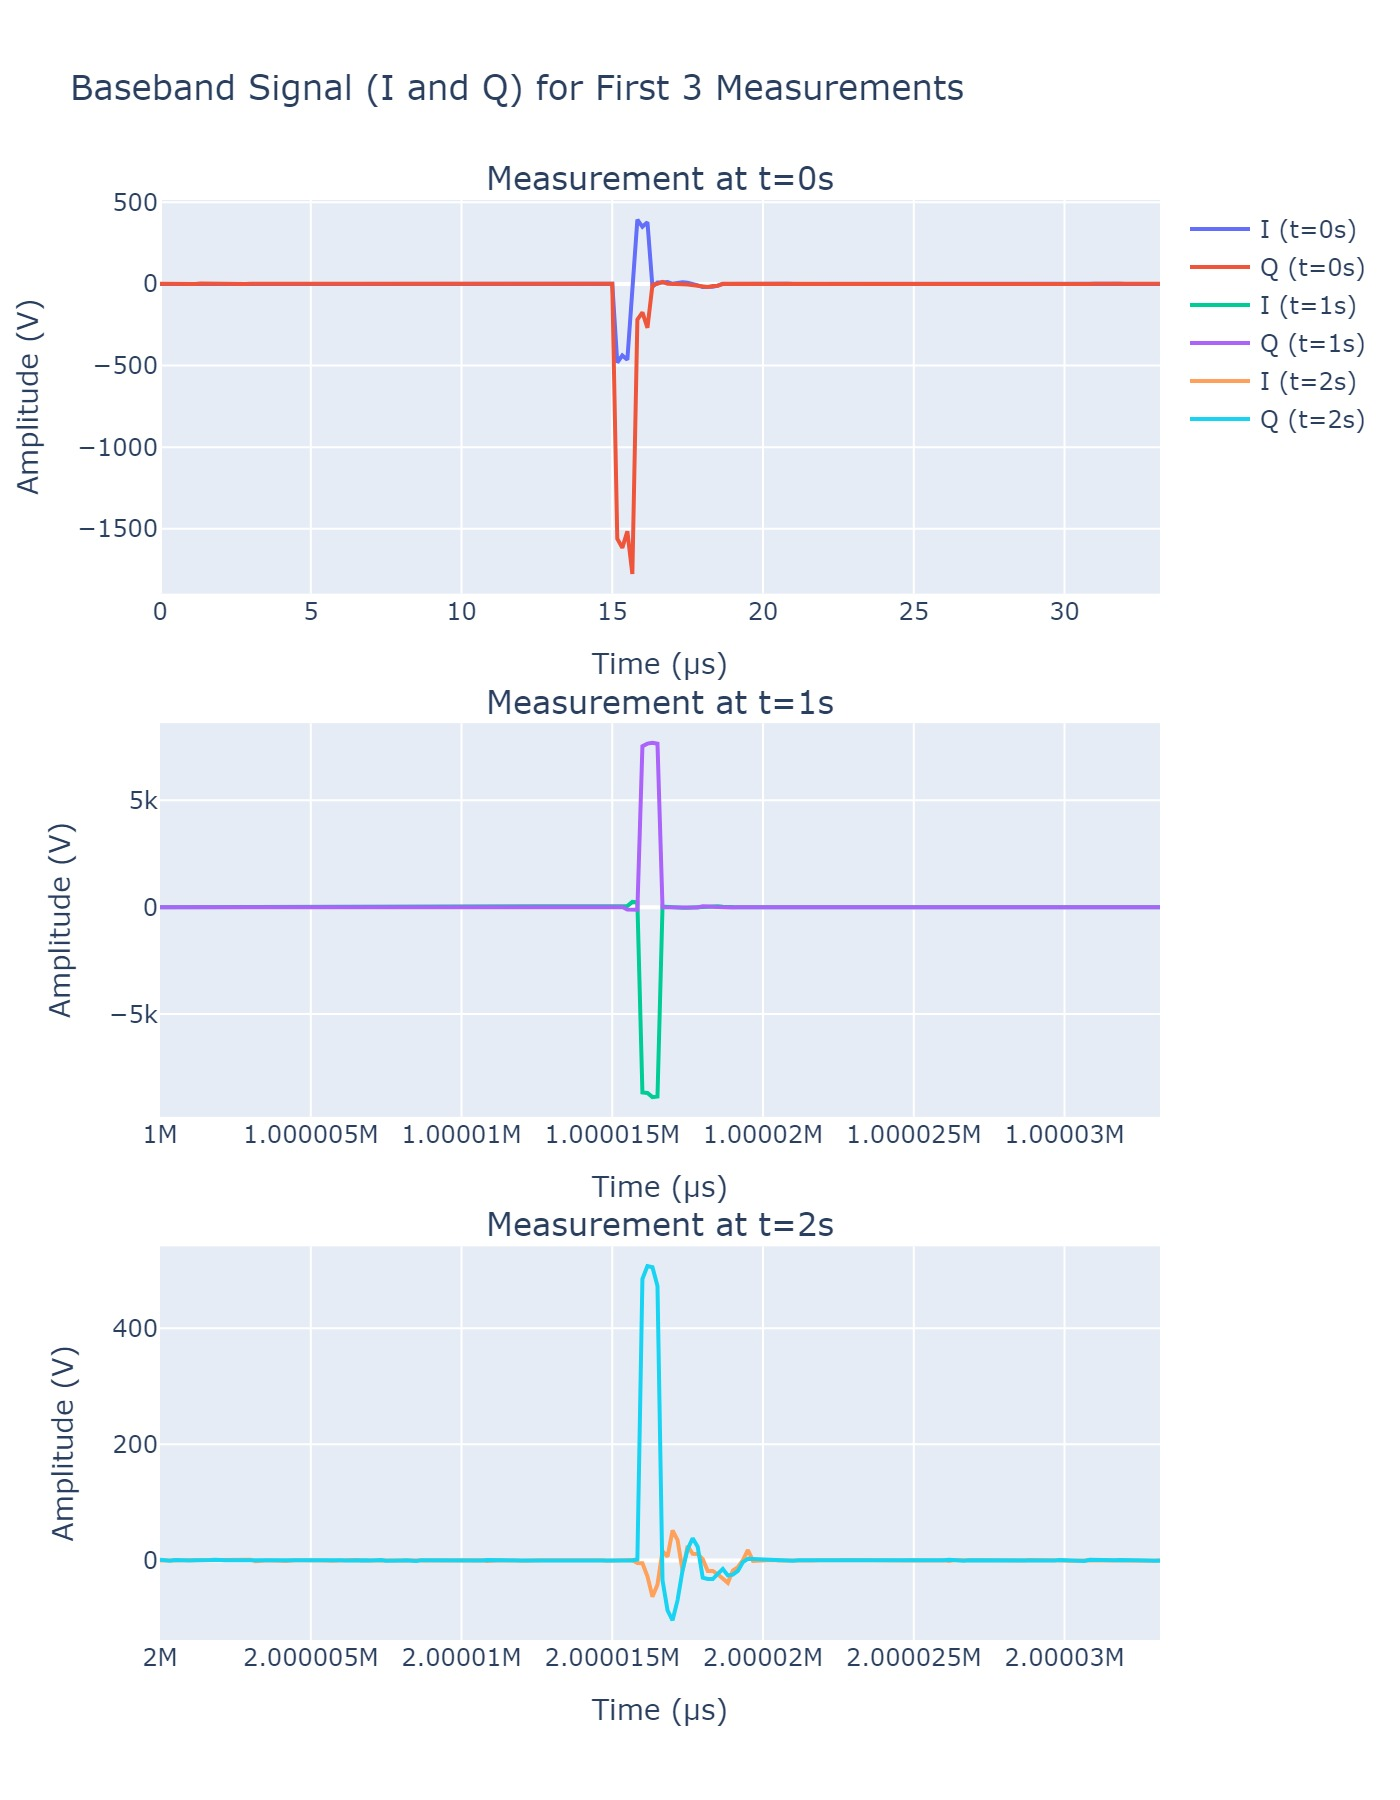

In [26]:
# Plot first 3 baseband signals using subplots
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplots with 3 rows
fig = make_subplots(
    rows=3,
    cols=1,
    subplot_titles=(
        f"Measurement at t={measurement_time[0]:.0f}s",
        f"Measurement at t={measurement_time[1]:.0f}s",
        f"Measurement at t={measurement_time[2]:.0f}s",
    ),
    vertical_spacing=0.09,
)

# Plot first 3 measurements
for idx in range(3):
    t = timestamp[idx, 0, :] * 1e6  # Convert to microseconds
    I = np.real(baseband[idx, 0, :])  # Real part (I channel)
    Q = np.imag(baseband[idx, 0, :])  # Imaginary part (Q channel)

    # Add I channel trace
    fig.add_trace(
        go.Scatter(
            x=t,
            y=I,
            mode="lines",
            name=f"I (t={measurement_time[idx]:.0f}s)",
            # line=dict(color="blue"),
        ),
        row=idx + 1,
        col=1,
    )

    # Add Q channel trace
    fig.add_trace(
        go.Scatter(
            x=t,
            y=Q,
            mode="lines",
            name=f"Q (t={measurement_time[idx]:.0f}s)",
            # line=dict(color="red"),
        ),
        row=idx + 1,
        col=1,
    )

# Update axes labels
for idx in range(3):
    fig.update_xaxes(title_text="Time (μs)", row=idx + 1, col=1)
    fig.update_yaxes(title_text="Amplitude (V)", row=idx + 1, col=1)

# Update layout
fig.update_layout(
    title="Baseband Signal (I and Q) for First 3 Measurements",
    height=900,
    showlegend=True,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Altimeter Signal Processing

Apply matched filtering to extract altitude from terrain ground return.

### Matched Filter Processing

**Implementation:**

The code uses `scipy.signal.convolve` to implement the matched filter:

1. Extract the transmitted pulse as matching coefficients (non-zero portion of amplitude array)
2. Convolve each received signal with the pulse replica
3. Use `mode='same'` to maintain output length

**Processing Gain:**

For this rectangular pulse, the matched filter provides SNR improvement of ~10*log10(N) dB where N is the filter length. The filter maximizes SNR by coherently integrating the signal energy.

**Output:**

The `range_profile` array contains the matched filter output for all measurements, with peaks indicating ground returns at specific ranges (altitudes).

In [27]:
# Import signal processing module
from scipy import signal

### Apply Matched Filter to Each Pulse ###

# Extract matching coefficients (transmitted pulse shape)
# Use only the non-zero portion of the amplitude array
matchingcoeff = amp[amp != 0]  # Pulse replica for matched filtering

# Initialize range profile storage [frames, pulses, samples]
range_profile = np.zeros_like(baseband, dtype=np.complex128)

for f_idx in range(0, len(measurement_time)):
    # Convolve received signal with pulse replica
    # mode='same' keeps output length same as input
    range_profile[f_idx, 0, :] = signal.convolve(
        baseband[f_idx, 0, :],  # Received baseband for this pulse
        matchingcoeff,  # Transmitted pulse (matched filter)
        mode="same",  # Keep same length as input
    )

print(f"Matched filtering complete:")
print(f"  Matched filter length: {len(matchingcoeff)} samples")
print(f"  Matched Filter SNR Improvement: ~{10*np.log10(len(matchingcoeff)):.1f} dB")
print(f"  Altitude measurement ready for extraction")

Matched filtering complete:
  Matched filter length: 3 samples
  Matched Filter SNR Improvement: ~4.8 dB
  Altitude measurement ready for extraction


### Generate Altitude Profile

The matched filter output provides the altitude profile showing terrain returns.

**Profile Characteristics:**

- **Peak location**: Range (altitude) to terrain
- **Peak amplitude**: Ground return strength
- **Signal spreading**: Terrain elevation variations

The profile is computed for each measurement time as the aircraft moves along the flight path, creating a time-range heatmap.


### Visualize Altitude Profile

Display the altitude profile evolution as a heatmap showing ground returns along the flight path.

**Heatmap Interpretation:**

- **X-axis**: Altitude (m) - computed as range = c*t/2
- **Y-axis**: Measurement time (s) along flight path
- **Color**: Amplitude in dB (logarithmic scale)
- **Bright regions**: Strong ground returns at ~4000m altitude
- **Color range**: Max to Max-100 dB for contrast

The heatmap shows how the terrain return evolves as the aircraft flies over the Grand Canyon terrain, with the main return consistently appearing at approximately 4000m altitude.

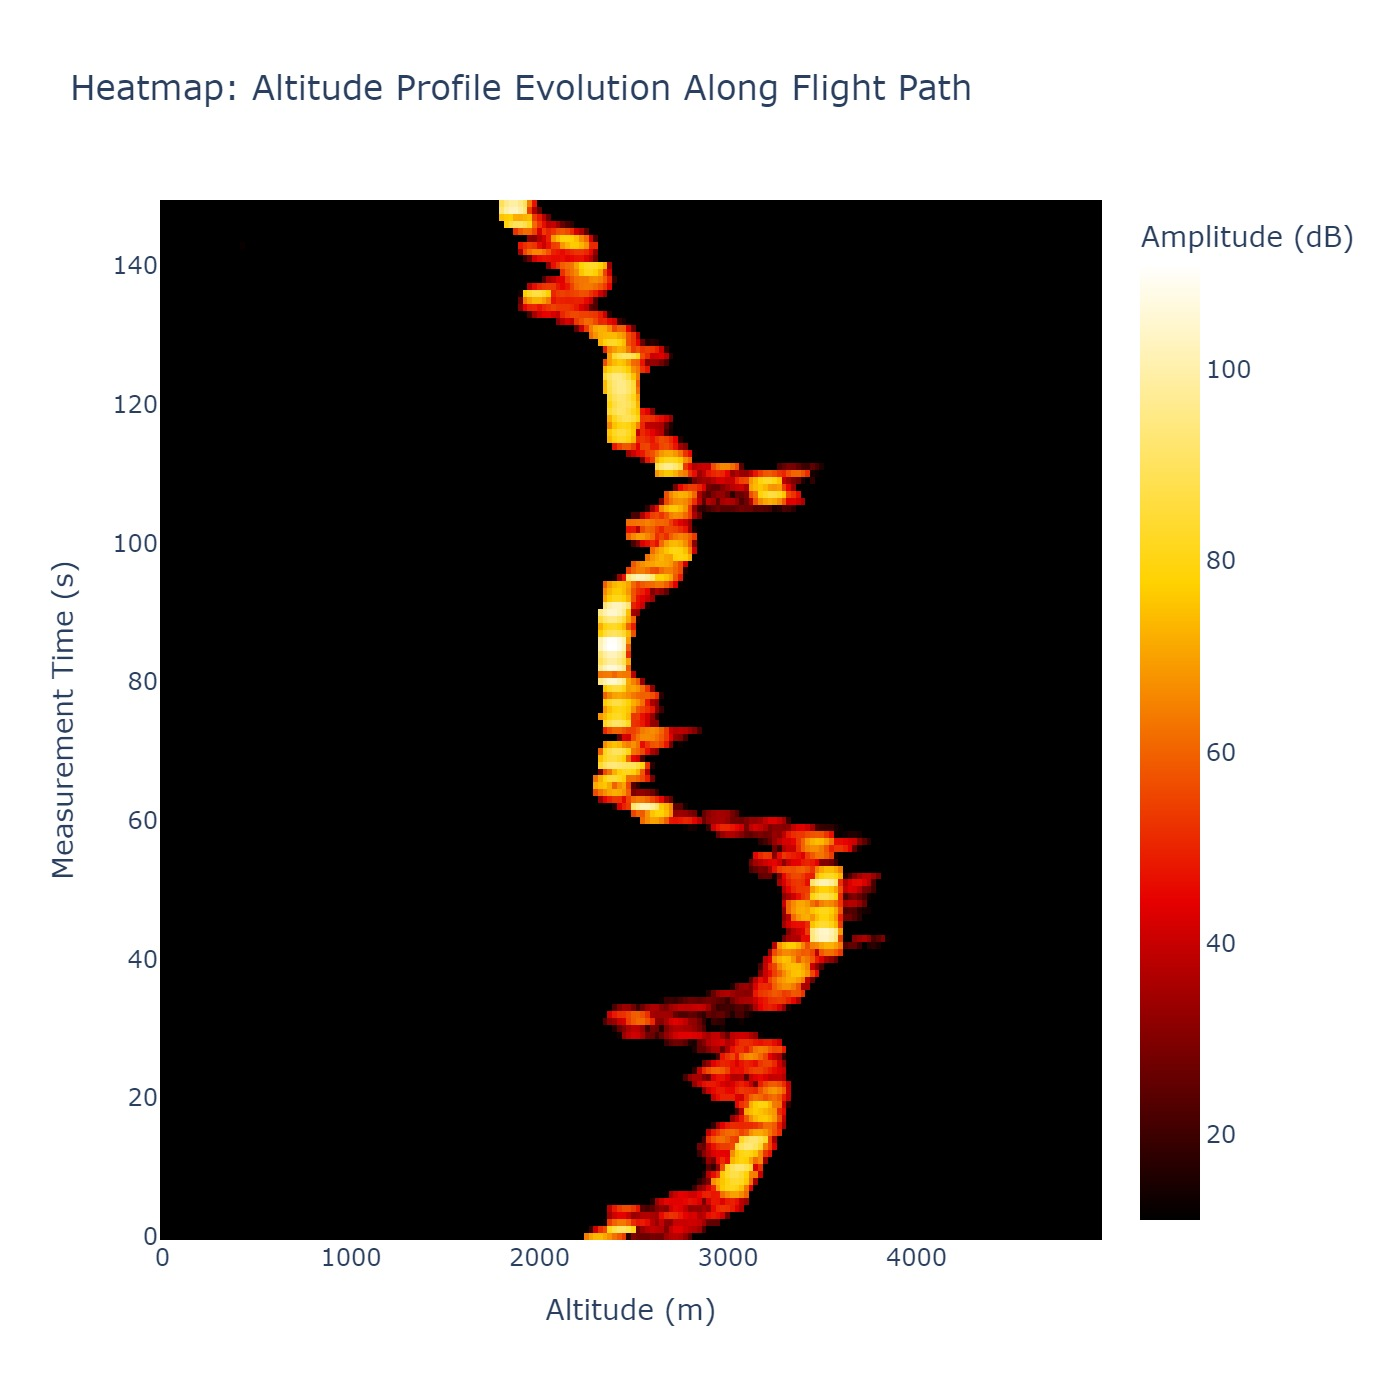

In [28]:
# Create range axis from time (convert to distance)
range_axis = mod_t * light_speed / 2  # Range = c*t/2

# Create heatmap visualization showing range profile evolution along flight path
import plotly.graph_objs as go

# Prepare data for heatmap: rows = measurement times, columns = range bins
n_measurements = len(measurement_time)
heatmap_data = 20 * np.log10(np.abs(range_profile[:, 0, :]))

# Calculate color scale limits: max to max-20
z_max = np.max(heatmap_data)
z_min = z_max - 100

# Create heatmap
fig = go.Figure(
    data=go.Heatmap(
        x=range_axis,
        y=measurement_time,
        z=heatmap_data,
        colorscale="Hot",
        zmin=z_min,
        zmax=z_max,
        colorbar=dict(title="Amplitude (dB)"),
    )
)

# Configure layout
fig.update_layout(
    title="Heatmap: Altitude Profile Evolution Along Flight Path",
    xaxis=dict(title="Altitude (m)", gridcolor="lightgray"),
    yaxis=dict(title="Measurement Time (s)", gridcolor="lightgray"),
    height=700,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

This notebook demonstrated how to simulate a pulse radar altimeter using RadarSimPy:

### Key Concepts

**RadarSimPy Implementation:**
- Configured pulse radar with `Radar`, `Transmitter`, and `Receiver` classes
- Defined custom antenna patterns with narrow downward-pointing beam
- Loaded 3D terrain models for realistic ground scatter simulation
- Generated baseband signals with terrain reflections
- Applied matched filtering for altitude extraction

**Altimeter Operation:**
- Measured altitude via time delay: h = cτ/2
- Achieved 50m resolution with 333ns pulse width
- Detected ground return at 4000m altitude
- Demonstrated terrain footprint averaging effects

### Experiment Further

Modify parameters to explore different scenarios:

**Altitude Resolution**: Change `range_res` (10m, 100m, 200m) to see precision vs. signal strength trade-offs

**Operating Altitude**: Vary radar altitude (1000m-8000m) to test range capability and footprint size

**Antenna Beamwidth**: Adjust power exponent (cos¹⁰⁰ to cos¹⁰⁰⁰) to change terrain footprint size

**Carrier Frequency**: Test different bands (4 GHz, 35 GHz) for atmospheric and penetration effects

**Peak Power**: Vary `tx_power` (50-90 dBm) to understand power requirements for different altitudes

### Resources

- [RadarSimPy Documentation](https://radarsimx.com)
- [RadarSimPy Simulator Module](https://radarsimx.github.io/radarsimpy/simulator.html)